# Homework: Basic Artificial Neural Networks

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

This homework requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- homework_modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)
- homework_differentiation.ipynb

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

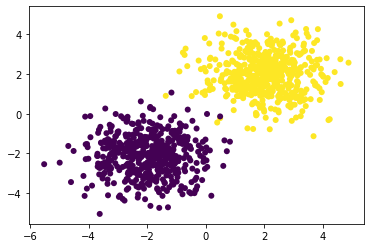

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [10]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [11]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [12]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

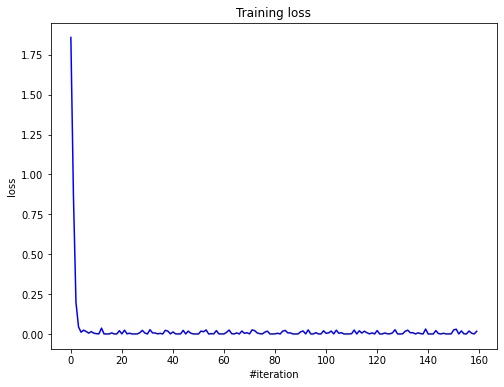

Current loss: 0.016654


In [13]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

### Show accuracy

Here I'll plot the correctly/wrongly classified points and show the accuracy score.

Accuracy: 0.9960


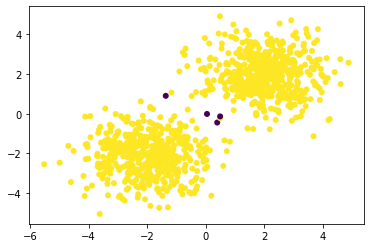

In [14]:
predictions = np.exp(net.forward(X)).argmax(axis=1)
truth = Y.argmax(axis=1)
correct = predictions == truth

plt.scatter(X[:,0],X[:,1], c = correct, edgecolors= 'none')
print(f'Accuracy: {correct.mean():.4f}')

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [15]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

One-hot encode the labels first.

In [16]:
from sklearn.preprocessing import OneHotEncoder

y_train = np.expand_dims(y_train, axis=1)
y_val = np.expand_dims(y_val, axis=1)
y_test = np.expand_dims(y_test, axis=1)

enc = OneHotEncoder().fit(y_train)

y_train = enc.transform(y_train).toarray()
y_val = enc.transform(y_val).toarray()
y_test = enc.transform(y_test).toarray()

print(X_train.shape, y_train.shape)

(50000, 28, 28) (50000, 10)


- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

In [25]:
# Training function
criterion = ClassNLLCriterion()

def construct_net(activation):
    net = Sequential()
    net.add(Flatten())
    net.add(Linear(28*28, 32))
    net.add(activation)
    net.add(Linear(32, 10))
    net.add(LogSoftMax())    

    return net

def train(model, data_x, data_y, batch_size, n_epoch, optimizer_config, visualize=False):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((data_x, data_y), batch_size):
            
            model.zeroGradParameters()
            
            # Forward
            predictions = model.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)
        
            # Backward
            dp = criterion.backward(predictions, y_batch)
            model.backward(x_batch, dp)
            
            # Update weights
            sgd_momentum(model.getParameters(), 
                        model.getGradParameters(), 
                        optimizer_config,
                        optimizer_state)      
            
            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)

        if visualize:
            plt.figure(figsize=(8, 6))
                
            plt.title("Training loss")
            plt.xlabel("#iteration")
            plt.ylabel("loss")
            plt.plot(loss_history, 'b')
            plt.show()
            
        print(f'Epoch {i+1}/{n_epoch}: Training loss {loss:.4f}')

### ReLU

In [26]:
# Define the net
net = construct_net(ReLU())

BATCH_SIZE = 128
N_EPOCHS = 25
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

loss_relu = train(net, X_train, y_train, BATCH_SIZE, N_EPOCHS, optimizer_config)

TypeError: 'ReLU' object is not callable

### ELU

In [23]:
# Define the net
net = construct_net(ELU())

loss_elu = train(net, X_train, y_train, BATCH_SIZE, N_EPOCHS, optimizer_config)

Epoch 24/25: Training loss 0.0179


### LeakyReLU

In [ ]:
# Define the net
net = construct_net(LeakyReLU())

loss_leaky_relu = train(net, X_train, y_train, BATCH_SIZE, N_EPOCHS, optimizer_config)

### SoftPlus

In [ ]:
# Define the net
net = construct_net(SoftPlus())

loss_softplus = train(net, X_train, y_train, BATCH_SIZE, N_EPOCHS, optimizer_config)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

In [12]:
# Your answer goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [13]:
# Your code goes here. ################################################

Print here your accuracy on test set. It should be around 90%.

In [14]:
# Your answer goes here. ################################################